In [ ]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [2]:
SOFT_CONN = True

input_graph = gen_two_community_graph(max_nodes_per_community=30, min_nodes_per_community=20, p_intra=0.5 , links = 1)
input_graph = torch.tensor(nx.to_numpy_array(input_graph))

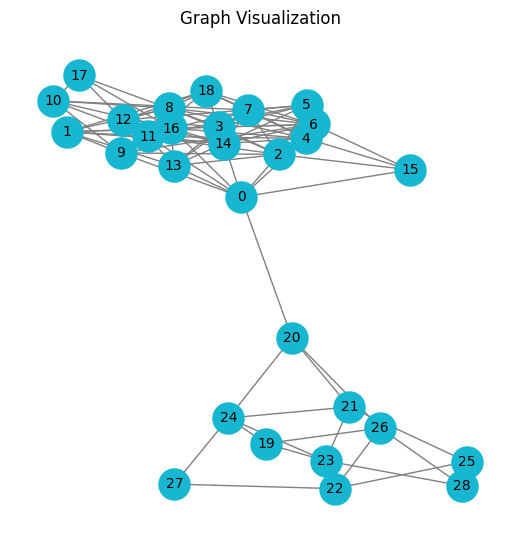

In [3]:
plot_graph(input_graph, labels=True)

In [5]:
class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


alpha = 0.002
niter = 1200
min_change = 0.001
update_steps = 3

sampler = MySampler(backend="cuda")
obs = sampler.observables(input_graph)

params, graphs = sampler.param_run(graph=input_graph,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:03<00:00, 360.59it/s]

number of accepted steps is:  1198
number of rejected samples:  2
number of effective updates is:  399


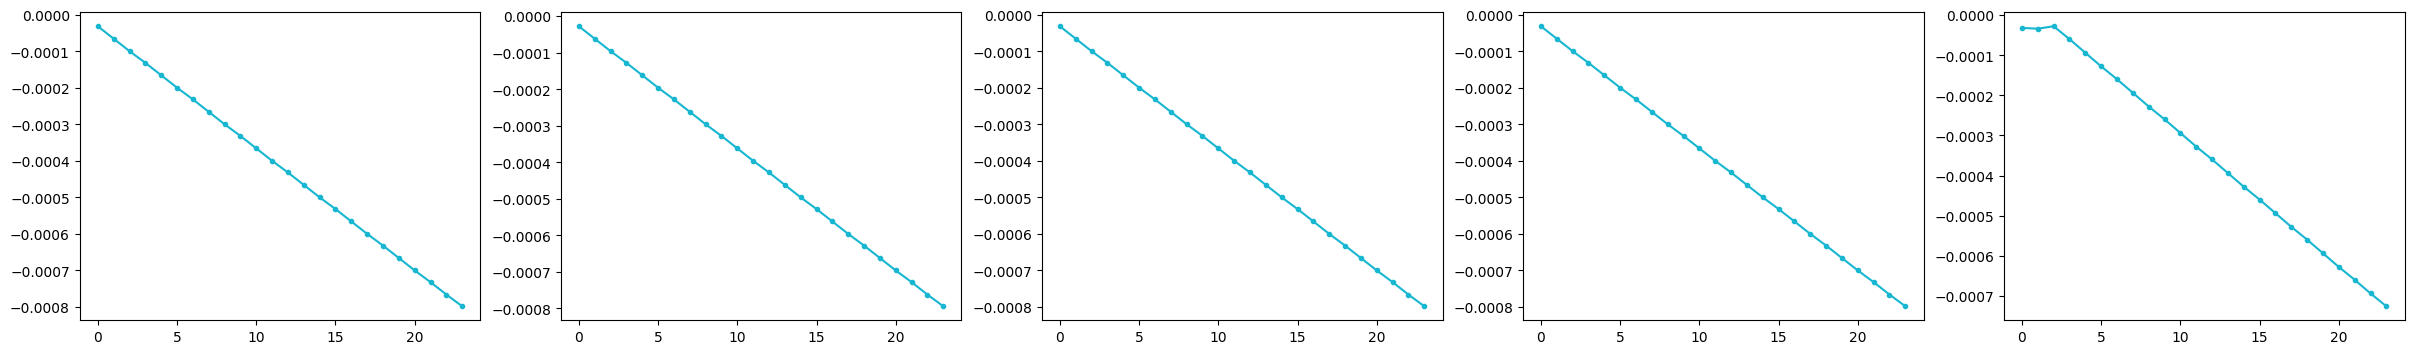

In [8]:
plot_params_iterations(params)

In [6]:
params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler.sample_run(graph=input_graph,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 1200/1200 [00:02<00:00, 406.90it/s]

number of accepted steps is:  1197
number of rejected samples:  3
Mean obs:  tensor([1.9162e+02, 4.0192e+02, 6.9584e+00, 1.3216e+01, 2.3526e-01],
       dtype=torch.float64)


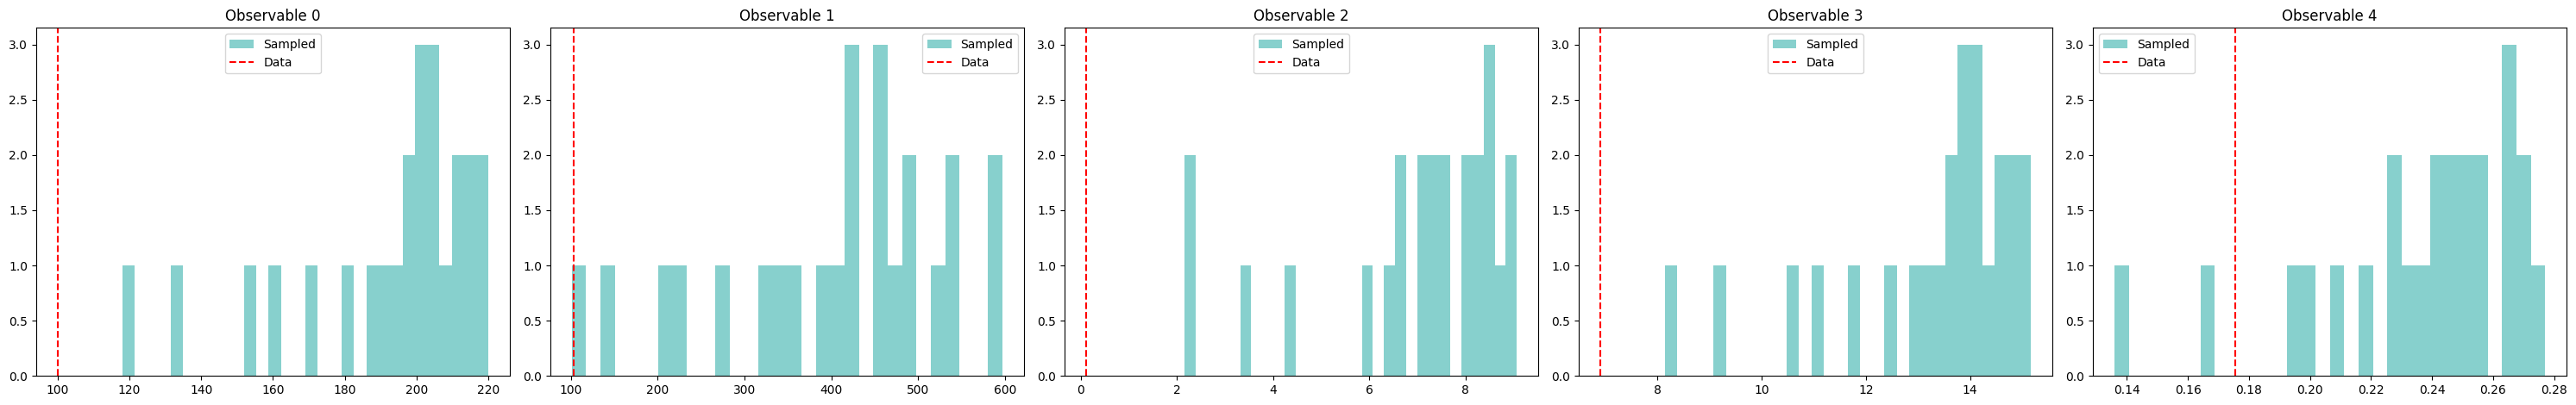

In [7]:
hist_obs_samples(observables, obs)